Continuation of the last notebook while the data loads there

In [1]:
#imports
import uproot as ur
import awkward as ak
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "6" #specify GPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import graph_util_splitdelta as gu
import plot_util as pu

from scipy.interpolate import interp1d

import Week7_PFNutils as W

import atlas_mpl_style as ampl #makes matplotlib follow atlas formal style
ampl.use_atlas_style()

2021-08-11 08:53:31.037641: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-11 08:53:43.695740: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-11 08:53:43.729804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-11 08:53:43.882305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-11 08:53:43.882364: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-11 08:53:43.956220: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2

In [2]:
import vector as v

v.register_awkward()

In [3]:
model_path = '/fast_scratch/atlas_images/v01-45/' 
data_path = '/data/atlas/'

In [18]:
events = ur.open(model_path+'rho_medium.root')

tree = events['EventTree']

In [19]:
rho211 = np.load(data_path+'rho_211.npz')
rhon211 = np.load(data_path+'rho_n211.npz')

In [20]:
#load up data
pipm_med = np.load(data_path+'pipm_medium.npz')
pi0_med = np.load(data_path+'pi0_medium.npz')

In [21]:
#extract data
X_pipm = pipm_med['X']
X_pi0 = pi0_med['X']

Y_label_pipm = pipm_med['Y_label']
Y_label_pi0 = pi0_med['Y_label']

clus_eta_pipm = pipm_med['clus_eta']
clus_eta_pi0 = pi0_med['clus_eta']

clus_pt_pipm = pipm_med['clus_pt']
clus_pt_pi0 = pi0_med['clus_pt']

clus_E_pipm = pipm_med['clus_e']
clus_E_pi0 = pi0_med['clus_e']

clus_et_pipm = pipm_med['clus_e_t']
clus_et_pi0 = pi0_med['clus_e_t']

In [22]:
X211 = rho211['X']
Y211 = np.ones(len(X211)) * 2
clus_eta211= rho211['clus_eta']
clus_pt211 = rho211['clus_pt']
clus_E211 = rho211['clus_e']
clus_et211 = rho211['clus_e_t']
deltar211 = rho211['deltaR']

In [23]:
Xn211 = rhon211['X']
Yn211 = np.ones(len(Xn211)) * 2
clus_etan211= rhon211['clus_eta']
clus_ptn211 = rhon211['clus_pt']
clus_En211 = rhon211['clus_e']
clus_etn211 = rhon211['clus_e_t']
deltarn211 = rhon211['deltaR']

In [33]:
len(X211), len(Xn211)

(97256, 97130)

In [34]:
#select size of datasets
X_all = np.concatenate((X_pipm[:97000], X_pi0[:97000], X211[:97000], Xn211[:97000]))
Y_all = tf.keras.utils.to_categorical(np.concatenate((Y_label_pipm[:97000],Y_label_pi0[:97000], Y211[:97000], Yn211[:97000])), num_classes=3)
eta = np.concatenate((clus_eta_pipm[:97000], clus_eta_pi0[:97000], clus_eta211[:97000], clus_etan211[:97000]))
E_T = np.concatenate((clus_et_pipm[:97000], clus_et_pi0[:97000], clus_et211[:97000], clus_etn211[:97000]))
pt = np.concatenate((clus_pt_pipm[:97000], clus_pt_pi0[:97000], clus_pt211[:97000], clus_ptn211[:97000]))
Eng = np.concatenate((clus_E_pipm[:97000], clus_E_pi0[:97000], clus_E211[:97000], clus_En211[:97000]))

In [35]:
len(X_all)

388000

In [4]:
from energyflow.utils import data_split


In [5]:
def splitdatdelR(dat, outfile, val, test):
    X, Y, clus_eta, clus_pt, clus_E, clus_et = dat
    
    (X_train, X_val, X_test, 
     Y_train, Y_val, Y_test,
     eta_train, eta_val, eta_test, 
     ET_train, ET_val, ET_test, 
     pt_train, pt_val, pt_test, 
     Eng_train, Eng_val, Eng_test) = data_split(X, Y, clus_eta, clus_et, clus_pt, clus_E, val=val, test=test)
    
    np.savez(data_path+outfile, X_train, X_val, X_test, Y_train, Y_val, Y_test, eta_train, eta_val, eta_test, ET_train, ET_val, ET_test, pt_train, pt_val, pt_test, Eng_train, Eng_val, Eng_test)

In [38]:
splitdatdelR((X_all, Y_all, eta, pt, Eng, E_T), 'nn_3classrho.npz', 80000, 108000)

In [5]:
file = np.load(data_path+'nn_3classrho.npz')

In [6]:
X_train = file['arr_0']
X_val = file['arr_1']
X_test = file['arr_2']
Y_train = file['arr_3']
Y_val = file['arr_4']
Y_test = file['arr_5']
eta_train = file['arr_6']
eta_val = file['arr_7']
eta_test = file['arr_8']

In [6]:
def model_noglob_3(X_train, X_val, X_test, Y_train, Y_val, Y_test, epochs, batch_size, filename):
    #run the model & create the metrics
    
    Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
   
    #make the model:
    pfn = PFN(input_dim=X_train.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, loss="categorical_crossentropy", output_dim=3)#, num_global_features =1)
    
    #try callbacks:
    callback = tf.keras.callbacks.ModelCheckpoint(data_path+filename, save_best_only=True)
    
    # train model
    history = pfn.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=1, callbacks=[callback])
    
    return history

In [11]:
hist = model_noglob_3(X_train, X_val, X_test, Y_train, Y_val, Y_test, 200, 1000, 'W15_rho3class.hdf5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
____________________________________________________________________________________________

2021-08-09 09:12:46.177604: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-08-09 09:12:49.754705: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


200/200 [==============================] - 51s 231ms/step - loss: 15.2125 - acc: 0.4214 - val_loss: 3.0912 - val_acc: 0.3146
Epoch 2/200
200/200 [==============================] - 41s 206ms/step - loss: 1.5509 - acc: 0.5198 - val_loss: 1.1017 - val_acc: 0.6060
Epoch 3/200
200/200 [==============================] - 40s 199ms/step - loss: 1.3752 - acc: 0.5373 - val_loss: 0.9144 - val_acc: 0.6118
Epoch 4/200
200/200 [==============================] - 40s 200ms/step - loss: 1.0119 - acc: 0.5827 - val_loss: 0.9382 - val_acc: 0.6186
Epoch 5/200
200/200 [==============================] - 41s 203ms/step - loss: 1.0866 - acc: 0.5696 - val_loss: 0.9107 - val_acc: 0.6113
Epoch 6/200
200/200 [==============================] - 39s 196ms/step - loss: 0.9382 - acc: 0.6020 - val_loss: 0.8805 - val_acc: 0.6293
Epoch 7/200
200/200 [==============================] - 40s 200ms/step - loss: 0.9040 - acc: 0.6127 - val_loss: 0.9674 - val_acc: 0.5949
Epoch 8/200
200/200 [==============================] - 39s 

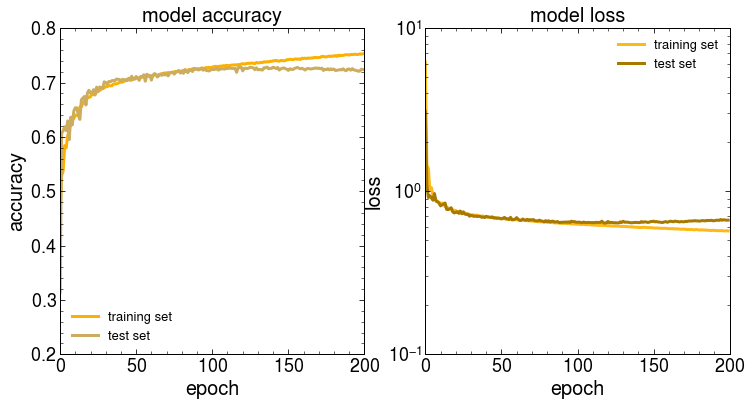

In [12]:
W.histplots(hist)

In [4]:
model = tf.keras.models.load_model(data_path+'W15_rho3class.hdf5')

In [7]:
eta_ranges = np.arange(0., 3.1, .1)+.05

selec_01 = abs(eta_test) < 0.1
selec_02 = (abs(eta_test) >= .1) & (abs(eta_test) < .2)
selec_03 = (abs(eta_test) >= .2) & (abs(eta_test) < .3)
selec_04 = (abs(eta_test) >= .3) & (abs(eta_test) < .4)
selec_05 = (abs(eta_test) >= .4) & (abs(eta_test) < .5)
selec_06 = (abs(eta_test) >= .5) & (abs(eta_test) < .6)
selec_07 = (abs(eta_test) >= .6) & (abs(eta_test) < .7)
selec_08 = (abs(eta_test) >= .7) & (abs(eta_test) < .8)
selec_09 = (abs(eta_test) >= .8) & (abs(eta_test) < .9)
selec_10 = (abs(eta_test) >= .9) & (abs(eta_test) < 1.)
selec_11 = (abs(eta_test) >= 1.) & (abs(eta_test) < 1.1)
selec_12 = (abs(eta_test) >= 1.1) & (abs(eta_test) < 1.2)
selec_13 = (abs(eta_test) >= 1.2) & (abs(eta_test) < 1.3)
selec_14 = (abs(eta_test) >= 1.3) & (abs(eta_test) < 1.4)
selec_15 = (abs(eta_test) >= 1.4) & (abs(eta_test) < 1.5)
selec_16 = (abs(eta_test) >= 1.5) & (abs(eta_test) < 1.6)
selec_17 = (abs(eta_test) >= 1.6) & (abs(eta_test) < 1.7)
selec_18 = (abs(eta_test) >= 1.7) & (abs(eta_test) < 1.8)
selec_19 = (abs(eta_test) >= 1.8) & (abs(eta_test) < 1.9)
selec_20 = (abs(eta_test) >= 1.9) & (abs(eta_test) < 2.)
selec_21 = (abs(eta_test) >= 2.) & (abs(eta_test) < 2.1)
selec_22 = (abs(eta_test) >= 2.1) & (abs(eta_test) < 2.2)
selec_23 = (abs(eta_test) >= 2.2) & (abs(eta_test) < 2.3)
selec_24 = (abs(eta_test) >= 2.3) & (abs(eta_test) < 2.4)
selec_25 = (abs(eta_test) >= 2.4) & (abs(eta_test) < 2.5)
selec_26 = (abs(eta_test) >= 2.5) & (abs(eta_test) < 2.6)
selec_27 = (abs(eta_test) >= 2.6) & (abs(eta_test) < 2.7)
selec_28 = (abs(eta_test) >= 2.7) & (abs(eta_test) < 2.8)
selec_29 = (abs(eta_test) >= 2.8) & (abs(eta_test) < 2.9)
selec_30 = (abs(eta_test) >= 2.9) & (abs(eta_test) < 3.)
selec_all = abs(eta_test) <= 3. 

eta_sel = [selec_01, selec_02, selec_03, selec_04, selec_05, selec_06, selec_07, selec_08, selec_09, selec_10,
              selec_11, selec_12, selec_13, selec_14, selec_15, selec_16, selec_17, selec_18, selec_19, selec_20,
              selec_21, selec_22, selec_23, selec_24, selec_25, selec_26, selec_27, selec_28, selec_29, selec_30,
              selec_all]

In [9]:
fps, tps, aucs, preds = W.metrics_ng(model, X_test, Y_test, eta_sel)

PFN AUC: 0.9588179094810138
PFN AUC: 0.9548315940869763
PFN AUC: 0.9629409028590364
PFN AUC: 0.9615900261904994
PFN AUC: 0.9588751366759005
PFN AUC: 0.9605848038047475
PFN AUC: 0.9534035730219746
PFN AUC: 0.9591615646258502
PFN AUC: 0.9471128529335194
PFN AUC: 0.9451469461059846
PFN AUC: 0.9412963181801646
PFN AUC: 0.9412941091349604
PFN AUC: 0.9423642703846048
PFN AUC: 0.9239934625882509
PFN AUC: 0.8564354092178955
PFN AUC: 0.8960988553604669
PFN AUC: 0.9159876219888649
PFN AUC: 0.9296497160049488
PFN AUC: 0.9212000979509716
PFN AUC: 0.9234884625972961
PFN AUC: 0.9234532357430638
PFN AUC: 0.9382422018227402
PFN AUC: 0.9322794826229566
PFN AUC: 0.9396417180985555
PFN AUC: 0.9177306690630123
PFN AUC: 0.9095335809258608
PFN AUC: 0.9513372956909361
PFN AUC: 0.9492235514473144
PFN AUC: 0.9645100565313893
PFN AUC: 0.9540849544605742
PFN AUC: 0.9377841764992016


In [28]:
preds

[array([[0.00494223, 0.8602683 , 0.1347895 ],
        [0.00099476, 0.9764579 , 0.0225474 ],
        [0.25827625, 0.00765883, 0.73406494],
        ...,
        [0.03048714, 0.89685434, 0.07265858],
        [0.21002242, 0.00805595, 0.78192157],
        [0.28263775, 0.00357176, 0.7137905 ]], dtype=float32),
 array([[0.01137487, 0.9197815 , 0.0688436 ],
        [0.22795556, 0.0099738 , 0.76207066],
        [0.34089205, 0.00203605, 0.6570719 ],
        ...,
        [0.27007255, 0.01447909, 0.7154484 ],
        [0.00758342, 0.0015732 , 0.9908434 ],
        [0.2903334 , 0.23602094, 0.4736457 ]], dtype=float32),
 array([[1.7765251e-01, 5.4479629e-01, 2.7755120e-01],
        [3.7680267e-04, 2.3257479e-02, 9.7636569e-01],
        [9.9852967e-01, 2.5371145e-04, 1.2167029e-03],
        ...,
        [2.2177020e-02, 1.9440301e-01, 7.8341997e-01],
        [1.9071023e-01, 9.2156930e-03, 8.0007410e-01],
        [8.7163905e-03, 9.0144432e-01, 8.9839324e-02]], dtype=float32),
 array([[1.02108126e-04, 9.7

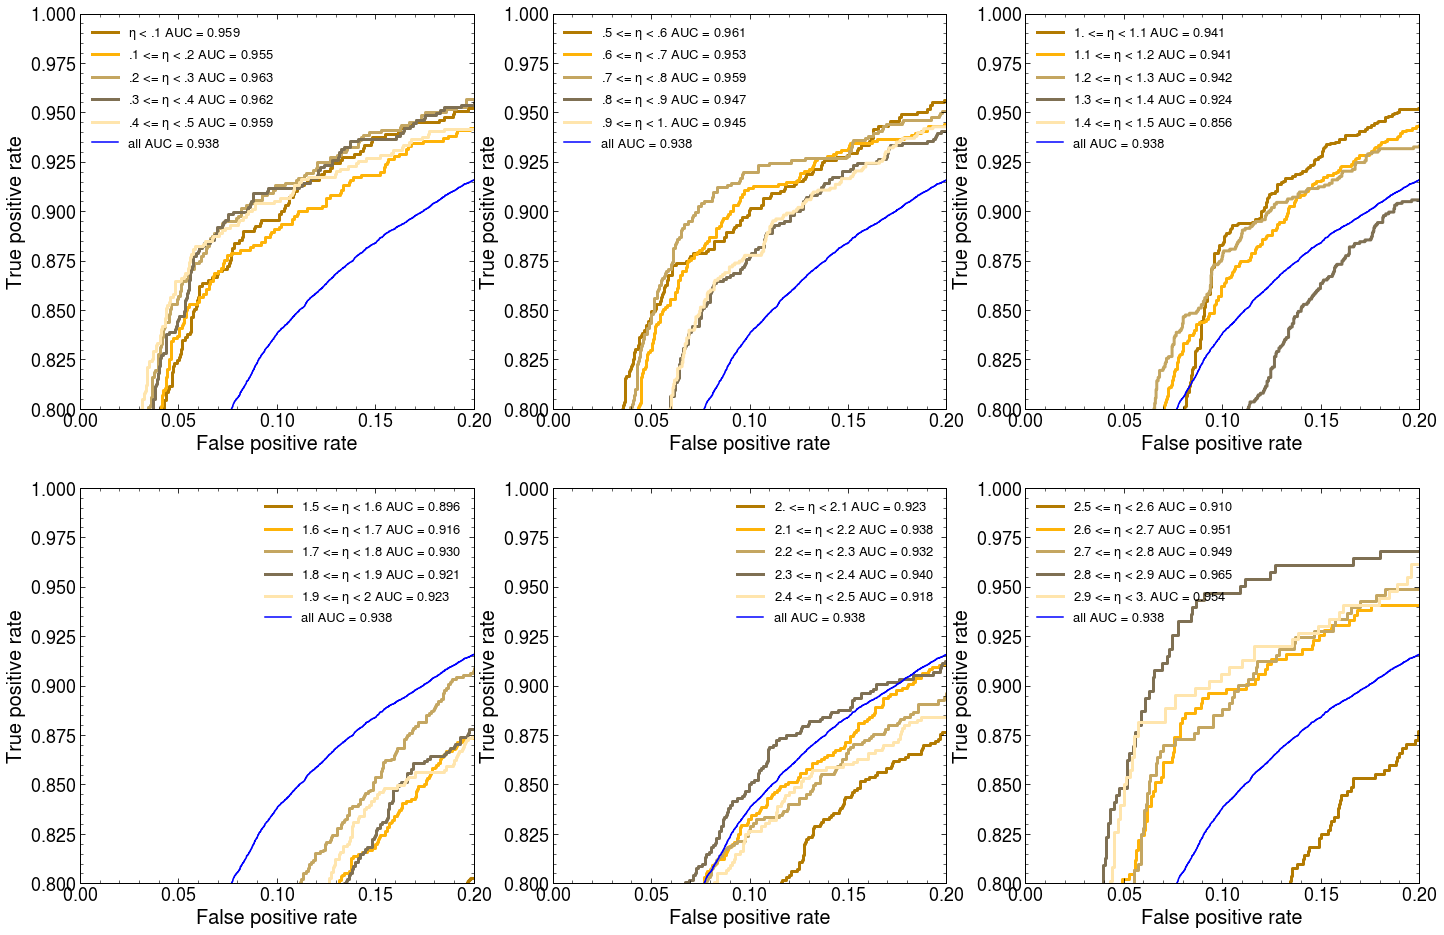

In [11]:
W.AUCplot(eta_ranges, fps, tps, aucs, rangetype='eta')

In [12]:
reg95 = W.interp95(fps, tps)

/home/kaelaekd/start_tf/LCStudies/classifier/Week7_PFNutils.py:82: RuntimeWarning: divide by zero encountered in true_divide
  fg.append(interp1d(tps[i], 1/fps[i]))


Text(0, 0.5, 'Rejection at 95\\% efficiency')

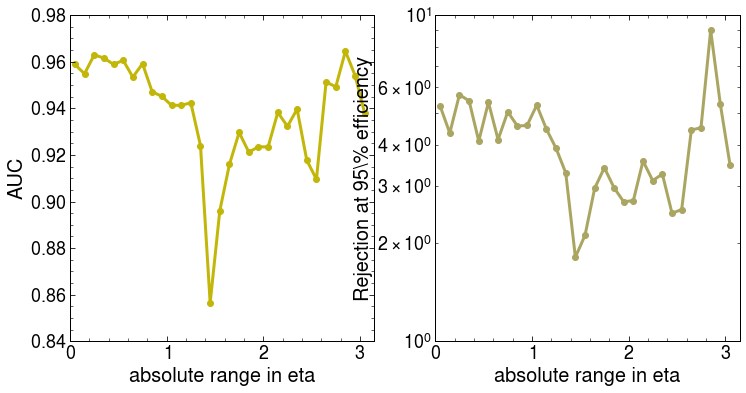

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,6])

ax1.set_xlim(0., max(eta_ranges)+.1)
ax1.plot(eta_ranges, aucs, linewidth=3, c='xkcd:olive yellow', marker='o')
ax1.set_xlabel('absolute range in eta')
ax1.set_ylabel('AUC')

ax2.semilogy()
ax2.set_xlim(0., max(eta_ranges)+.1)
ax2.plot(eta_ranges, reg95, linewidth=3, c='xkcd:khaki', marker='o')
ax2.set_xlabel('absolute range in eta')
ax2.set_ylabel('Rejection at 95\% efficiency') #PLOT THIS AGAIN comparing it to one of the old ones

In [24]:
# I think same amount should mean same amount of 0, 1, 2 not same amount of all 4 so try again:
#select size of datasets
X_all = np.concatenate((X_pipm[:194000], X_pi0[:194000], X211[:97000], Xn211[:97000]))
Y_all = tf.keras.utils.to_categorical(np.concatenate((Y_label_pipm[:194000],Y_label_pi0[:194000], Y211[:97000], Yn211[:97000])), num_classes=3)
eta = np.concatenate((clus_eta_pipm[:194000], clus_eta_pi0[:194000], clus_eta211[:97000], clus_etan211[:97000]))
E_T = np.concatenate((clus_et_pipm[:194000], clus_et_pi0[:194000], clus_et211[:97000], clus_etn211[:97000]))
pt = np.concatenate((clus_pt_pipm[:194000], clus_pt_pi0[:194000], clus_pt211[:97000], clus_ptn211[:97000]))
Eng = np.concatenate((clus_E_pipm[:194000], clus_E_pi0[:194000], clus_E211[:97000], clus_En211[:97000]))

In [27]:
len(X_all)

582000

In [29]:
splitdatdelR((X_all, Y_all, eta, pt, Eng, E_T), 'nn_3classrho_larger.npz', 100000, 82000)

In [6]:
file = np.load(data_path+'nn_3classrho_larger.npz')

In [7]:
X_train = file['arr_0']
X_val = file['arr_1']
X_test = file['arr_2']
Y_train = file['arr_3']
Y_val = file['arr_4']
Y_test = file['arr_5']
eta_train = file['arr_6']
eta_val = file['arr_7']
eta_test = file['arr_8']
pt_train = file['arr_12']
pt_val = file['arr_13']
pt_test = file['arr_14']

In [9]:
#hist2 = model_noglob_3(X_train, X_val, X_test, Y_train, Y_val, Y_test, 200, 1000, 'W15_rho3class_larger.hdf5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

2021-08-09 13:08:41.293910: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-09 13:08:41.323653: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/200


2021-08-09 13:08:42.121059: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-08-09 13:08:45.847254: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


400/400 [==============================] - 85s 200ms/step - loss: 9.4474 - acc: 0.4450 - val_loss: 1.6462 - val_acc: 0.4775
Epoch 2/200
400/400 [==============================] - 78s 194ms/step - loss: 1.1239 - acc: 0.5111 - val_loss: 1.4731 - val_acc: 0.4747
Epoch 3/200
400/400 [==============================] - 76s 190ms/step - loss: 1.0445 - acc: 0.5335 - val_loss: 0.9449 - val_acc: 0.5703
Epoch 4/200
400/400 [==============================] - 76s 190ms/step - loss: 0.9213 - acc: 0.5669 - val_loss: 0.8861 - val_acc: 0.5783
Epoch 5/200
400/400 [==============================] - 76s 189ms/step - loss: 0.8874 - acc: 0.5817 - val_loss: 0.9534 - val_acc: 0.5589
Epoch 6/200
400/400 [==============================] - 75s 188ms/step - loss: 0.8679 - acc: 0.5919 - val_loss: 0.8306 - val_acc: 0.6059
Epoch 7/200
400/400 [==============================] - 76s 189ms/step - loss: 0.8255 - acc: 0.6085 - val_loss: 0.7903 - val_acc: 0.6299
Epoch 8/200
400/400 [==============================] - 74s 1

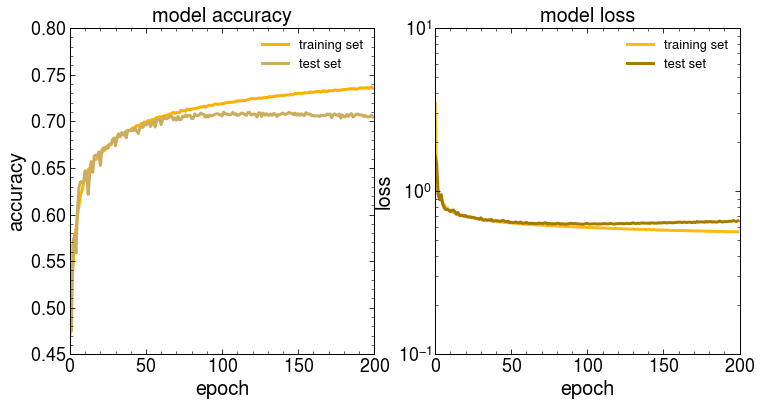

In [10]:
W.histplots(hist2)

In [6]:
# I'm curious to try a global model?

W.GlobalModel(X_train, X_val, X_test, Y_train, Y_val, Y_test, eta_train, eta_val, eta_test, 150, 1000, 1, 'W15_3classGlobal.hdf5', 100, nClass=3)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

2021-08-10 12:08:15.407481: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12800000000 exceeds 10% of free system memory.
2021-08-10 12:08:32.126780: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-10 12:08:32.175648: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/150


2021-08-10 12:08:33.212963: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-08-10 12:08:36.908326: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


400/400 [==============================] - ETA: 0s - loss: 8.2122 - acc: 0.4450

2021-08-10 12:11:01.964801: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3200000000 exceeds 10% of free system memory.


400/400 [==============================] - 160s 388ms/step - loss: 8.1989 - acc: 0.4451 - val_loss: 1.5412 - val_acc: 0.4807
Epoch 2/150
400/400 [==============================] - 75s 188ms/step - loss: 1.1042 - acc: 0.5144 - val_loss: 0.9128 - val_acc: 0.5595
Epoch 3/150
400/400 [==============================] - 72s 181ms/step - loss: 0.9568 - acc: 0.5459 - val_loss: 0.8991 - val_acc: 0.5643
Epoch 4/150
400/400 [==============================] - 72s 181ms/step - loss: 0.9076 - acc: 0.5698 - val_loss: 0.8594 - val_acc: 0.6035
Epoch 5/150
400/400 [==============================] - 72s 180ms/step - loss: 0.8596 - acc: 0.5925 - val_loss: 0.8539 - val_acc: 0.5994
Epoch 6/150
400/400 [==============================] - 72s 181ms/step - loss: 0.8368 - acc: 0.6034 - val_loss: 0.8442 - val_acc: 0.6085
Epoch 7/150
400/400 [==============================] - 72s 180ms/step - loss: 0.8137 - acc: 0.6170 - val_loss: 0.7941 - val_acc: 0.6331
Epoch 8/150
400/400 [==============================] - 72s 

In [10]:
X_glob_train_1 = np.stack((np.array(eta_train), np.array(pt_train)), axis=1)
X_glob_vali_1 = np.stack((np.array(eta_val), np.array(pt_val)), axis=1)
X_glob_test_1 = np.stack((np.array(eta_test), np.array(pt_test)), axis=1)

In [11]:
W.GlobalModel(X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_train_1, X_glob_vali_1, X_glob_test_1, 150, 1000, 2, 'W15_3classGlobaletaNpt.hdf5', 100, nClass=3)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_14 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_14[0][0]              
____________________________________________________________________________________________

2021-08-11 09:56:39.157205: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12800000000 exceeds 10% of free system memory.


Epoch 1/150


2021-08-11 09:56:55.002229: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-08-11 09:56:59.070063: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


400/400 [==============================] - ETA: 0s - loss: 4.7566 - acc: 0.4639

2021-08-11 09:58:34.365386: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3200000000 exceeds 10% of free system memory.


400/400 [==============================] - 109s 260ms/step - loss: 4.7498 - acc: 0.4639 - val_loss: 1.2033 - val_acc: 0.4827
Epoch 2/150
400/400 [==============================] - 49s 122ms/step - loss: 1.0371 - acc: 0.5317 - val_loss: 0.9526 - val_acc: 0.5400
Epoch 3/150
400/400 [==============================] - 48s 121ms/step - loss: 0.9253 - acc: 0.5648 - val_loss: 0.8675 - val_acc: 0.5917
Epoch 4/150
400/400 [==============================] - 49s 121ms/step - loss: 0.8670 - acc: 0.5895 - val_loss: 0.8555 - val_acc: 0.5920
Epoch 5/150
400/400 [==============================] - 49s 122ms/step - loss: 0.8464 - acc: 0.6016 - val_loss: 0.8453 - val_acc: 0.6119
Epoch 6/150
400/400 [==============================] - 48s 120ms/step - loss: 0.8156 - acc: 0.6151 - val_loss: 0.8043 - val_acc: 0.6103
Epoch 7/150
400/400 [==============================] - 47s 117ms/step - loss: 0.7959 - acc: 0.6240 - val_loss: 0.7867 - val_acc: 0.6233
Epoch 8/150
400/400 [==============================] - 48s 